In [1]:
from typing import Any

import lightning.pytorch as pl
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
import mlflow
from torch.utils.data import DataLoader, Dataset

from src.ml.data.splitting import create_data_splits
from src.ml.modeling import (
    model_factory,
    optimizer_factory,
)
from src.ml.utils.set_seed import set_seed

from datetime import datetime
from loguru import logger
from pathlib import Path
from shutil import copy, copytree, rmtree

import yaml

from src.ml.train_neural_network import train_neural_network
from src.ml.data import data_sets_factory
from src.ml.preprocessing import preprocessing_factory
from src.ml.utils.set_seed import set_seed

In [2]:
CONFIG_FILE = Path("src/ml/config.yaml")

In [3]:
torch.set_default_device(torch.device("cpu"))

In [4]:
# load config file

logger.info("Loading config file.")

with open(CONFIG_FILE, "r") as f:
    config = yaml.safe_load(f)

2024-12-17 16:07:04.232 | INFO     | __main__:<module>:3 - Loading config file.


In [5]:
# load data

logger.info("Loading data.")

_, data_sets = next(iter(data_sets_factory(**config["data_set"])))

# preprocess data

logger.info("Start preprocessing.")

for preprocessing_step in config["preprocessing"]:
    logger.info("Perform {} preprocessing.", preprocessing_step["name"])

    transform = preprocessing_factory(**preprocessing_step)
    data_sets = transform(data_sets)

dataset = data_sets

2024-12-17 16:07:04.898 | INFO     | __main__:<module>:3 - Loading data.
2024-12-17 16:07:12.819 | INFO     | __main__:<module>:9 - Start preprocessing.
2024-12-17 16:07:12.819 | INFO     | __main__:<module>:12 - Perform add_taxa_names preprocessing.
2024-12-17 16:07:13.740 | INFO     | __main__:<module>:12 - Perform add_clade_information preprocessing.
2024-12-17 16:07:15.158 | INFO     | __main__:<module>:12 - Perform remove_tree preprocessing.


In [6]:
train_dataset, val_dataset, test_dataset = create_data_splits(
    dataset, **config["training"]["splitting_config"]
)

In [7]:
train_loader = DataLoader(train_dataset, **config["training"]["dataloader_config"])
test_loader = DataLoader(test_dataset,batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=128)

optimizer = optimizer_factory(**config["training"]["optimizer_config"])
model = model_factory(
    optimizer=optimizer,
    input_example=train_dataset[0],
    **config["training"]["model_config"],
)

In [9]:
from src.ml.modeling.weight_sharing_tree_flow import WeightSharingTreeFlow

model = WeightSharingTreeFlow.load_from_checkpoint("ml_data/models/debug_weight_sharing_2024_12_17_15_31_17/yule-10_140/epoch=05-val_loss=9.70.ckpt")
model = model.eval()

In [40]:
latent_space

array([[ 0.        ,  0.        ,  0.        , ..., -0.09691751,
         0.13800073, -1.0078886 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.12568367,
         0.011922  , -0.7995157 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.56304085,
         0.3578967 ,  2.1148107 ],
       ...,
       [-0.3915987 ,  0.        ,  0.        , ...,  0.31384563,
         0.87005424,  0.55006075],
       [ 0.        ,  0.        ,  0.        , ...,  0.31923008,
         1.126937  , -0.6518445 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.04873502,
         0.27961862, -1.395756  ]], dtype=float32)

<Axes: >

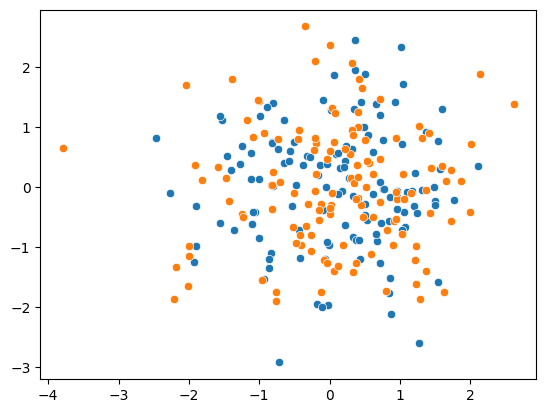

In [42]:
import seaborn as sns
sample = next(iter(val_loader))
latent_space = model.forward(sample)["z"].detach().numpy()
sns.scatterplot(x=latent_space[:, -1], y=latent_space[:, -2])

prior_latent_space = model.prior.sample((128, 2,)).detach().numpy()
sns.scatterplot(x=prior_latent_space[:, 0], y=prior_latent_space[:, 1])

In [43]:
i = iter(val_loader)

In [44]:
sample = next(i)
model.forward(sample)["z"] 

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0969,  0.1380, -1.0079],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.1257,  0.0119, -0.7995],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5630,  0.3579,  2.1148],
        ...,
        [-0.3916,  0.0000,  0.0000,  ...,  0.3138,  0.8701,  0.5501],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.3192,  1.1269, -0.6518],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0487,  0.2796, -1.3958]],
       grad_fn=<NanToNumBackward0>)

RuntimeError: The size of tensor a (9) must match the size of tensor b (63) at non-singleton dimension 1

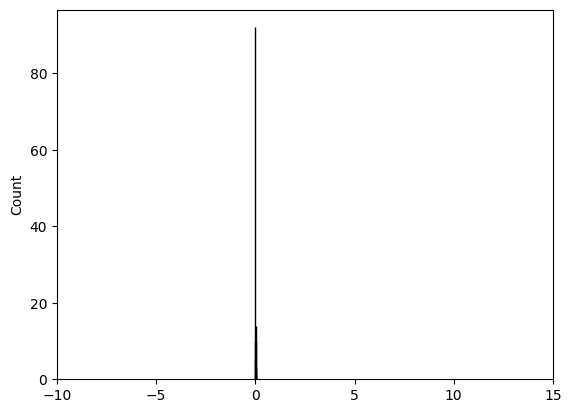

In [45]:
import matplotlib.pyplot as plt
prior = model.prior.sample((128, 9,))
latent = model.forward(sample)
rs = model.inverse(latent)["branch_lengths"]
rs = rs.detach().numpy()
sns.histplot(rs[:, 0])
plt.xlim(-10, 15)
prior = model.prior.sample((128, 9,))
latent = model.forward(sample)
latent["z"] = prior.clone()
rs = model.inverse(latent)["branch_lengths"]
rs = rs.detach().numpy()
sns.histplot(rs[:, 0])
plt.xlim(-0.0, 0.02)